# Load squared exponential approximation precomputed in data/*.json

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
from kl_decomposition import galerkin, kl_tensor

# Exponential kernel
path_decomp_list = ["data/cauchy.json",
                    "data/exp.json",
                    "data/matern.json",
                    "data/powexp06.json",
                    "data/rq.json",
                    "data/exp_squared.json"]


def get_kl_decomp(path_decomp, comp_degree=100, quad=600, g=4.0, N_eval=1000, dim=2):
    print(f"Loading decomposition from {path_decomp}...")
    with open(path_decomp, "r") as f:
        squared_approx = json.load(f)

    # available decomposition sizes
    decomp_size = max([int(i) for i in list(squared_approx.keys())])
    a_coeff = squared_approx[str(decomp_size)]['a']
    b_coeff = np.exp(squared_approx[str(decomp_size)]['b'])

    A_all = []
    print(f"Computing {dim}-dimensional KL decomposition with {comp_degree} components...")
    for b in b_coeff:
        print(f"Processing coefficient with b = {b}...")
        A_all.append(galerkin.assemble_duffy(f=b, degree=comp_degree, quad=quad, gx=g))
    print("Assembling the tensor...")
    eigenvalues, eigenvectors = kl_tensor.spectral_blocks(A_all, a_coeff, dim, N_eval=N_eval)
    print("Evaluating eigenfunctions...")
    lambdas_sorted, psi_sorted = kl_tensor.evaluate_eigenfunctions(
        eigenvalues, eigenvectors, comp_degree,
        np.linspace(0, 1, 200))
    return lambdas_sorted, psi_sorted

# Computing the KL decomposition of selected covariance functions

In [3]:
all_results = {}
for path in path_decomp_list:
    lambdas_sorted, psi_sorted = get_kl_decomp(path, comp_degree=150, quad=1500, g=4.0, N_eval=1500, dim=2)
    all_results[path[5:-5]] = {
        "lambdas": lambdas_sorted,
        "psi": psi_sorted
    }

Loading decomposition from data/cauchy.json...
Computing 2-dimensional KL decomposition with 150 components...
Processing coefficient with b = 0.04554407838742314...
Processing coefficient with b = 0.5167605418313906...
Processing coefficient with b = 1.715648752702553...
Processing coefficient with b = 4.202217885717452...
Processing coefficient with b = 9.407727113267837...
Processing coefficient with b = 20.89791343470133...
Processing coefficient with b = 47.61741901030484...
Processing coefficient with b = 113.00372906571786...
Processing coefficient with b = 282.2811202003305...
Processing coefficient with b = 750.6957511425621...
Processing coefficient with b = 2157.575642226334...
Processing coefficient with b = 6849.817537383227...
Processing coefficient with b = 24862.147987763638...
Processing coefficient with b = 109566.67867336846...
Processing coefficient with b = 664456.7700475913...
Processing coefficient with b = 8071290.978800899...
Assembling the tensor...
Evaluating

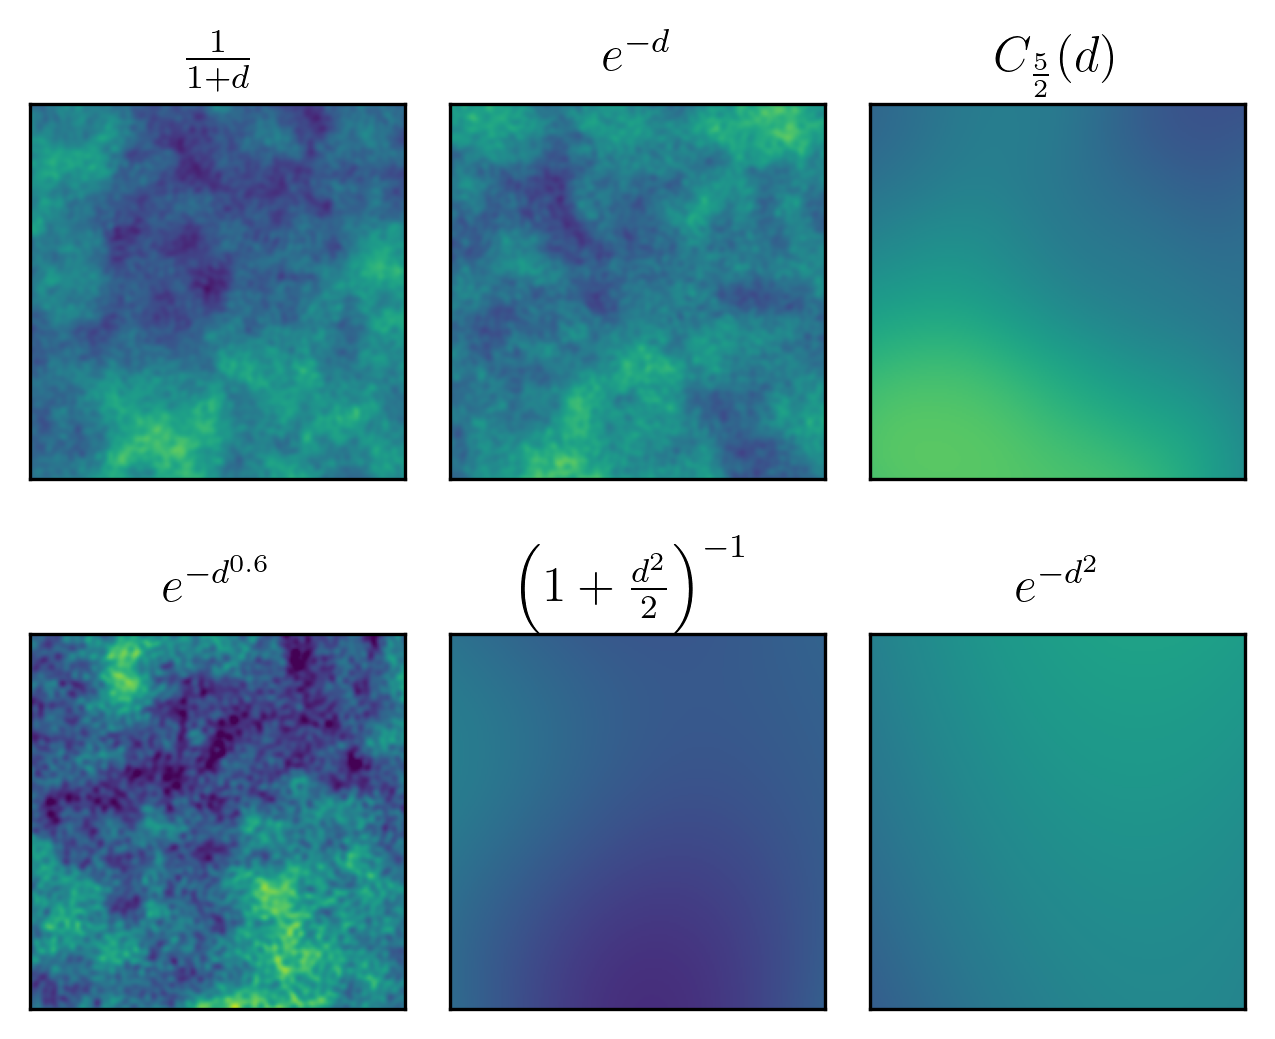

In [60]:
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.size": 10,
        "axes.labelsize": 10,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    }
)


titles = [r"$\frac{1}{1+d}$", 
            r"$e^{-d}$",
            r'$C_{\frac{5}{2}}(d)$',
            r"$e^{-d^{0.6}}$",
            r'$\left(1 + \frac{d^2}{2}\right)^{-1}$',
            r"$e^{-d^2}$"]

n_kernels = len(all_results)
n_cols = 3
n_rows = int(np.ceil(n_kernels / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(4.35, 3.7), dpi=300,
                         sharex=True,
                         sharey=True
                         )

# *Almost* zero spacing between panels
fig.subplots_adjust(
    wspace=0.0, hspace=0.0,     # zero horizontal, tight vertical
    left=0.08, right=0.995,
    bottom=0.06, top=0.88        # slightly tighter vertical padding
)

vmin, vmax = -2, 2
for idx, (key, value) in enumerate(all_results.items()):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col] if n_rows > 1 else axes[col]
    sample = kl_tensor.generate_raandom_sample(value["lambdas"], value["psi"])
    im = ax.imshow(sample, vmin=vmin, vmax=vmax, aspect='equal', cmap='viridis', rasterized=False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_title(titles[idx], pad=8)
# Hide unused axes
for idx in range(n_kernels, n_rows * n_cols):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col] if n_rows > 1 else axes[col]
    ax.axis('off')
plt.tight_layout()
fig.savefig("kl_samples.pdf", bbox_inches="tight")
plt.show()

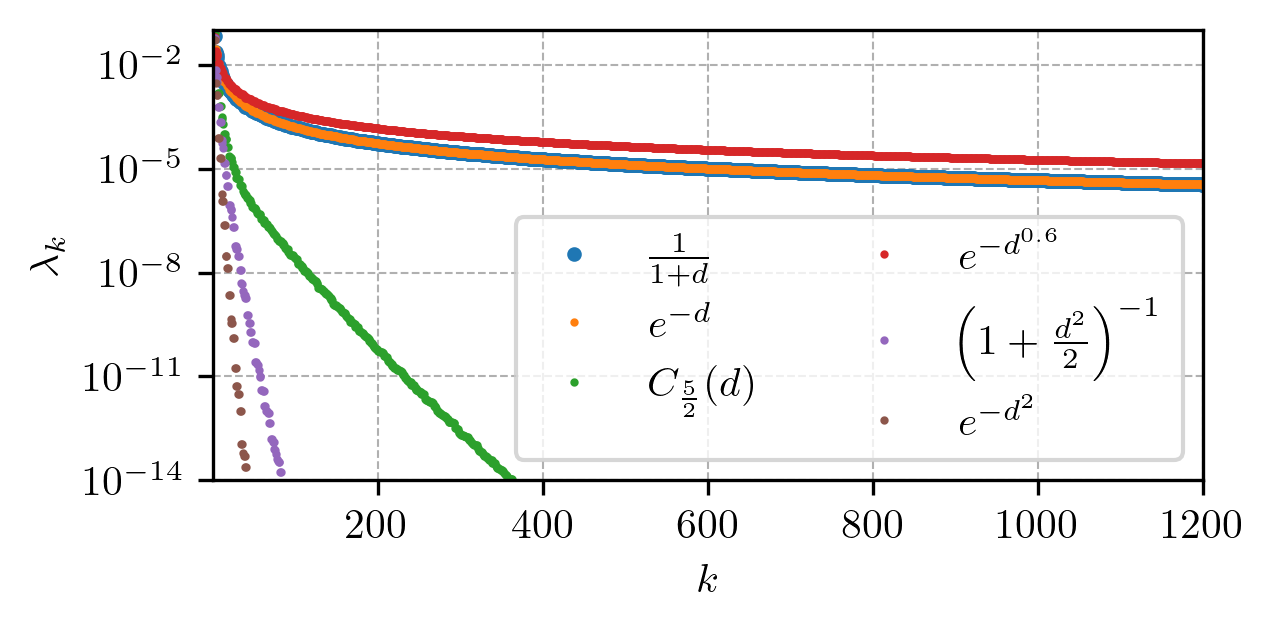

In [59]:
plt.rcParams.update(
    {
        "text.usetex": True,
        "font.family": "serif",
        "font.size": 10,
        "axes.labelsize": 10,
        "legend.fontsize": 10,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    }
)

n_kernels = len(all_results)
n_cols = 3
n_rows = int(np.ceil(n_kernels / n_cols))

fig = plt.figure(figsize=(4.35, 2.2), dpi=300)

markers = ['^', 'v', '^', 'v', '^', 'v' ]
marker_size = [5, 2, 2, 2, 2,2]
for idx, (key, value) in enumerate(all_results.items()):
    plt.plot(np.arange(1,len(value["lambdas"])+1), value["lambdas"], label=titles[idx], ls='None', marker='.', markersize=marker_size[idx])

plt.yscale('log')
plt.xlabel(r"$k$")
plt.ylabel(r"$\lambda_k$")
plt.legend(ncols=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.ylim(1e-14,1e-1)
plt.xlim(1, 1200)
plt.tight_layout()
fig.savefig("kl_eigenvalues.pdf", bbox_inches="tight")
plt.show()